# **Version 1**


---


#### Importing the necessary libraries

In [ ]:
import pickle
import numpy as np
import os
import string
from collections import Counter
from PIL import Image
 
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet import preprocess_input
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Add, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Layer

In [ ]:
main_dir = '/content/drive/My Drive/ImageCaptioning/'

#### Loading the annotations file, pre-processing it and saving it as a descriptions.txt file

In [ ]:
#### LOADING ANNOTATIONS FILE, PREPROCESSING IT AND SAVING IT AS 'DESCRIPTIONS.TXT
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.strip().split('\t')
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		desc = desc.split()
		desc = [word.lower() for word in desc]
		desc = [w.translate(table) for w in desc]
		desc = [word for word in desc if len(word)>1]
		descriptions[key] =  ' '.join(desc)

# save descriptions to file, one per line
def save_doc(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + '\t' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = main_dir + 'annotations_ajio_v3.txt'
doc = load_doc(filename)
print('Finished loading annotations.txt')
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
print("Finished cleaning descriptions")
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
#save_doc(descriptions, main_dir+'descriptions_v2_m1.txt')

Finished loading annotations.txt
Loaded: 8400 
Finished cleaning descriptions
Vocabulary Size: 1495


#### Splitting the dataset

In [ ]:
### SPLITTING DATASET
import random
product_ids = list(descriptions.keys())
random.shuffle(product_ids)
train_product_ids = product_ids[:int(0.8*len(product_ids))]
val_product_ids = product_ids[int(0.9*len(product_ids)):int(0.95*len(product_ids))]
test_product_ids = product_ids[int(0.95*len(product_ids)):]
print(len(product_ids))
print(len(train_product_ids))
print(len(val_product_ids))
print(len(test_product_ids))

8400
6720
420
420


#### Some pre-processing to find the vocab_size, max_length_of_caption for the model

In [ ]:
### PREPROCESSING CAPTIONS FOR TRAINING
def load_captions(descriptions,train_product_ids):
    train_captions=[]
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions.append('startseq '+descriptions[image_id]+' endseq')
    
    return train_captions

train_captions = load_captions(descriptions,train_product_ids)
val_captions = load_captions(descriptions, val_product_ids)
test_captions = load_captions(descriptions, test_product_ids)

In [ ]:
corpus = []
for caption in val_captions+train_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
        vocab.append(token)
        
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))

Number of original tokens 1392
Number of tokens after threshold 1392
1392


In [ ]:
print(word_to_index)

{'startseq': 1, 'broadway': 2, 'hooded': 3, 'puffer': 4, 'jacket': 5, 'with': 6, 'zip': 7, 'pockets': 8, 'endseq': 9, 'coldshoulder': 10, 'longline': 11, 'coat': 12, 'zipfront': 13, 'batwing': 14, 'sleeves': 15, 'heathered': 16, 'hoodie': 17, 'insert': 18, 'biker': 19, 'furline': 20, 'collar': 21, 'raglan': 22, 'buttondown': 23, 'hunting': 24, 'flap': 25, 'plaid': 26, 'epaulettes': 27, 'textured': 28, 'quilted': 29, 'front': 30, 'spread': 31, 'doublebreasted': 32, 'panelled': 33, 'blazer': 34, 'notched': 35, 'lapel': 36, 'bomber': 37, 'houndstooth': 38, 'print': 39, 'solid': 40, 'embroidered': 41, 'padded': 42, 'contrast': 43, 'hems': 44, 'woven': 45, 'tweed': 46, 'sleeveless': 47, 'trench': 48, 'frontopen': 49, 'bobble': 50, 'trims': 51, 'asymmetrical': 52, 'openfront': 53, 'furlined': 54, 'rookie': 55, 'rock': 56, 'glamyr': 57, 'ruffled': 58, 'flared': 59, 'printed': 60, 'branding': 61, 'knitted': 62, 'metallic': 63, 'delta': 64, 'ridge': 65, 'down': 66, 'faux': 67, 'fur': 68, 'trim'

In [ ]:
## max length of train captions

def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption(train_captions+val_captions+test_captions)

Maximum length of caption=  12


#### Loading the GloVe embeddings for the model

In [ ]:
### LOADING GLOVE EMBEDDINGS
embeddings_index = {} # empty dictionary
f = open(main_dir+'glove.6B.50d.txt', encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
## Embedding matrix
embedding_dim = 50

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_index.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(1393, 50)

#### Extracting the zip folder of images

In [ ]:
from zipfile import ZipFile

zip = ZipFile(main_dir+'/images_v3.zip',mode='r')
zip.extractall()

#### Extracting the images features using VGG-16 and storing it in a dictionary

In [ ]:

def load_img_features(product_ids):
	features=dict()
	product_ids_new = []
	image_dir ='images_v3/'
	in_layer = Input(shape=(224, 224, 3))
	model = VGG16(include_top=False, input_tensor=in_layer)
	for j,id in enumerate(product_ids): 
		print(j)
		try:
		  image_name = image_dir+id+'.jpg'
		  image=  load_img(image_name,target_size=(224, 224,3))
		  image = img_to_array(image)
		  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		  image = preprocess_input(image)
		  feature = model.predict(image, verbose=0)
		  product_ids_new.append(id)
		  features[id] = feature.reshape(7,7,512)
		except OSError:
		  print("Error with file")
  
	print("Loaded", len(features.keys()) ,"number of features" )
	print(features[id].shape)
	print(type(features[id]))
	return features, product_ids_new

train_features, train_product_ids = load_img_features(train_product_ids)
val_features, val_product_ids = load_img_features(val_product_ids)
test_features, test_product_ids = load_img_features(test_product_ids)

In [ ]:
print(train_features[train_product_ids[0]].flatten().reshape(-1,1).shape)

(25088, 1)


#### Loading captions

In [ ]:
def load_captions_dict(descriptions,train_product_ids):
    train_captions=dict()
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions[image_id]= 'startseq '+descriptions[image_id]+' endseq'
    
    return train_captions

train_captions = load_captions_dict(descriptions,train_product_ids)
val_captions = load_captions_dict(descriptions, val_product_ids)
test_captions = load_captions_dict(descriptions, test_product_ids)

#### Defining the model

In [ ]:
inputs1 = Input(shape=(7,7,512,))
conv1 = Conv2D(filters = 3, kernel_size=(3,3))(inputs1)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
fe1 = Dropout(0.4)(pool1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length_caption,))
se1 = Embedding(vocab_size,50, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
flatten2 = Flatten()(decoder2)
outputs = Dense(vocab_size, activation='softmax')(flatten2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 3)      13827       input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 2, 2, 3)      0           conv2d_1[0][0]                   
____________________________________________________________________________________________

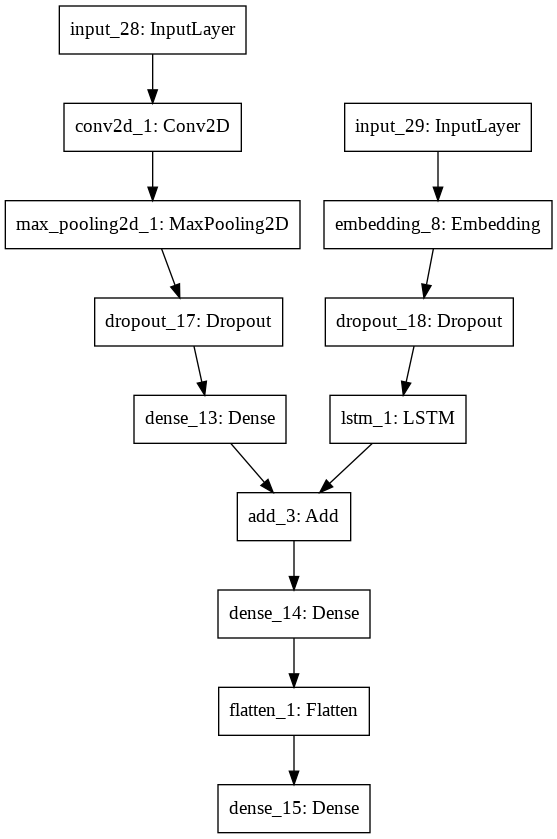

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file=main_dir+'model.png')

#### Setting the GloVe embeddings matrix as the embeddings layer

In [ ]:
print(model.layers[4])

model.layers[4].set_weights([embedding_matrix])
model.layers[4].trainable = False

#### Defining the custom data generator

In [ ]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc in descriptions.items():
            n+=1
            # retrieve the photo feature
            temp=main_dir
            
            photo = photos[key]
      
            for abc in range(1):
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, dtype='float64')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
             
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                 
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(X1, dtype='float64'),
                        np.array(X2, dtype='float64')], 
                       np.array(y, dtype='float64')]
                X1, X2, y = list(), list(), list()
                n=0

#### Finally! Training the model

In [ ]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-4,decay=1e-5))
epochs = 10
number_pics_per_batch = 16
steps = len(train_captions)//number_pics_per_batch
temp = main_dir

generator = data_generator(train_captions, train_features, word_to_index, max_length_caption, number_pics_per_batch)
val_generator = data_generator(val_captions, val_features,  word_to_index, max_length_caption, number_pics_per_batch)

In [ ]:
output_dir = main_dir + 'model1/'
if os.path.exists(output_dir) == False:
  os.mkdir(output_dir)

from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(min_lr = 1e-7, monitor='val_loss', patience = 1, factor = 0.5, verbose=1)

history = model.fit_generator(generator, validation_data=val_generator, validation_steps=8,
                                   epochs=5, steps_per_epoch=steps, verbose=1,callbacks=[reduce_lr],shuffle=True)
model.save(output_dir+'ajio_v3_20.h5')

Epoch 1/5
419/419 [==============================] - 19s 45ms/step - loss: 2.2742 - val_loss: 1.7875
Epoch 2/5
419/419 [==============================] - 19s 45ms/step - loss: 2.2727 - val_loss: 2.7438

Epoch 00002: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 3/5
419/419 [==============================] - 19s 45ms/step - loss: 2.2689 - val_loss: 2.9916

Epoch 00003: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 4/5
419/419 [==============================] - 19s 46ms/step - loss: 2.2659 - val_loss: 2.4813

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 5/5
419/419 [==============================] - 19s 45ms/step - loss: 2.2624 - val_loss: 1.7857


#### Loading the trained model.

In [ ]:
from keras.models import load_model

output_dir = main_dir + 'model1/'
model = load_model(output_dir+'ajio_v3.h5')

In [ ]:
print(test_captions)

{'ajio_441024673_offwhite': 'startseq camouflage print crewneck tshirt endseq', 'ajio_410166008_krc': 'startseq vintage destroyed polo tshirt endseq', 'ajio_440971881_black': 'startseq antibacterial training seamless crewneck tshirt endseq', 'ajio_460363241_black': 'startseq typographic print slim fit crewneck tshirt endseq', 'ajio_440975308_green': 'startseq justice league typographic print crewneck tshirt endseq', 'ajio_460369921_navy': 'startseq polo tshirt with patch pocket endseq', 'ajio_460542275_black': 'startseq typographic print crewneck sleeveless tshirt endseq', 'ajio_460481263_red': 'startseq typographic print crewneck tshirt endseq', 'ajio_460278362_denim': 'startseq slim fit typographic print crewneck tshirt endseq', 'ajio_440991792_navy': 'startseq lion king print crewneck tshirt endseq', 'ajio_460557017_black': 'startseq printed crewneck tshirt endseq', 'ajio_460369493_grey': 'startseq polotshirt with contrast collar and sleeves endseq', 'ajio_460443515_grey': 'startseq

#### Testing the model!

420
ajio_460466129_grey


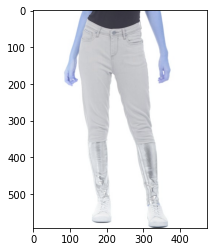

1/1 [==============================] - 0s 7ms/step
Actual output: startseq foil print highrise jeans endseq
Predicted output: midrise skinny jeans


In [ ]:
import matplotlib.pyplot as plt
import cv2

def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length_caption):
    sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
    sequence = pad_sequences([sequence], maxlen = max_length_caption)
    yhat = model.predict([photo,sequence],verbose=1)
    yhat = np.argmax(yhat)
    word = index_to_word[yhat]
    in_text+=' '+word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

print(len(test_product_ids))
z=54
pic= test_product_ids[z]
print(pic)
image = test_features[pic].reshape(1,7,7,512)
plt.imshow(cv2.imread('images_v3/'+pic+'.jpg'))
plt.show()
result = greedySearch(image)
print("Actual output:",test_captions[pic])
print("Predicted output:",result)

# **Newer Versions with Attention layer**

---

#### Importing the required packages

In [1]:
import pickle
import numpy as np
import os
import cv2
import string
from collections import Counter
from PIL import Image

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Add, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Concatenate, Flatten
from tensorflow.keras.layers import LSTM, Bidirectional, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2, VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam
import random
import json

#### Creating the requirements file for notebooks

In [4]:
!pip3 install pipreqsnb

  Created wheel for pipreqsnb: filename=pipreqsnb-0.2.1-cp36-none-any.whl size=3930 sha256=6420014be787bf193006d98482deab0b4f1b6de966d1f7309d3c2dd81d0765b2
  Stored in directory: /root/.cache/pip/wheels/2e/8d/04/f96b3fe905109d97e1663420287f765f0ce3ca7920b34a06e4
Successfully built pipreqsnb


In [7]:
!pipreqsnb --savepath 'requirements.txt' '/content/drive/My Drive/Colab Notebooks/ImageCaptioning.ipynb'

pipreqs  --savepath requirements.txt .//__temp_pipreqsnb_folder/
INFO: Successfully saved requirements file in requirements.txt


#### Loading the annotations file, pre-processing it

In [ ]:
main_dir = '/content/drive/My Drive/ImageCaptioning/'

In [ ]:
#### LOADING ANNOTATIONS FILE, PREPROCESSING IT AND SAVING IT AS 'DESCRIPTIONS.TXT
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.strip().split('\t')
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		desc = desc.split()
		desc = [word.lower() for word in desc]
		desc = [w.translate(table) for w in desc]
		desc = [word for word in desc if len(word)>1]
		descriptions[key] =  ' '.join(desc)

# save descriptions to file, one per line
def save_doc(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + '\t' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = main_dir + 'annotations_v2.txt'
doc = load_doc(filename)
print('Finished loading', filename)
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
print("Finished cleaning descriptions")
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
#save_doc(descriptions, main_dir+'descriptions_v2.txt')

Finished loading /content/drive/My Drive/ImageCaptioning/annotations_v2.txt
Loaded: 8835 
Finished cleaning descriptions
Vocabulary Size: 1143


In [ ]:
## WITH CATEGORIES

#### LOADING ANNOTATIONS FILE, PREPROCESSING IT AND SAVING IT AS 'DESCRIPTIONS.TXT
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	cat_mapping = dict()
	for line in doc.split('\n'):
		tokens = line.strip().split('\t')
		if len(line) < 2:
			continue
		image_id, image_desc, image_cat = tokens[0], tokens[1], tokens[2]
		image_id = image_id.split('.')[0]
		image_desc = image_desc
		if image_id not in mapping:
			mapping[image_id] = image_desc
			cat_mapping[image_id] = image_cat
	return mapping, cat_mapping

def clean_descriptions(descriptions):
	table = str.maketrans('', '', string.punctuation)
	for key, desc in descriptions.items():
		desc = desc.split(' ')
		desc = [word.lower() for word in desc]
		desc = [w.translate(table) for w in desc]
		desc = [word for word in desc if len(word)>1]
		descriptions[key] =  ' '.join(desc)

# save descriptions to file, one per line
def save_doc(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + '\t' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

filename = main_dir + 'annotations_ajio_v4_full(2).txt'
doc = load_doc(filename)
print('Finished loading', filename)
descriptions, categories = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
print("Finished cleaning descriptions")
all_tokens = ' '.join(descriptions.values()).split()
vocabulary = set(all_tokens)
print('Vocabulary Size: %d' % len(vocabulary))
unq_categories = set(categories.values())
print('Number of categories: %d' % len(unq_categories))
#save_doc(descriptions, main_dir+'descriptions_v2.txt')

Finished loading /content/drive/My Drive/ImageCaptioning/annotations_ajio_v4_full(2).txt
Loaded: 39000 
Finished cleaning descriptions
Vocabulary Size: 4026
Number of categories: 13


#### Shuffling the train, val and test data

In [ ]:
product_ids = list(descriptions.keys())
random.shuffle(product_ids)
train_product_ids = product_ids[:int(0.9*len(product_ids))]
random.shuffle(train_product_ids)
val_product_ids = product_ids[int(0.9*len(product_ids)):int(0.95*len(product_ids))]
random.shuffle(val_product_ids)
test_product_ids = product_ids[int(0.95*len(product_ids)):]
random.shuffle(test_product_ids)
print(len(product_ids))
print(len(train_product_ids))
print(len(val_product_ids))
print(len(test_product_ids))

8835
7951
442
442


#### Pre-processing to find vocab_size and max_caption_length

In [ ]:
### PREPROCESSING CAPTIONS FOR TRAINING
def load_captions(descriptions,train_product_ids):
    train_captions=[]
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions.append('startseq '+descriptions[image_id]+' endseq')
    
    return train_captions

train_captions = load_captions(descriptions,train_product_ids)
val_captions = load_captions(descriptions, val_product_ids)
test_captions = load_captions(descriptions, test_product_ids)

In [ ]:
### WORD TO INDEX DICTIONARY

corpus = []
for caption in val_captions+train_captions+test_captions:
    for token in caption.split():
        corpus.append(token)
        
hash_map = Counter(corpus)
vocab = []
for token,count in hash_map.items():
        vocab.append(token)
        
print('Number of original tokens',len(hash_map))
print('Number of tokens after threshold',len(vocab))

word_to_index = {}
index_to_word = {}
    
for idx,token in enumerate(vocab):
    word_to_index[token] = idx+1
    index_to_word[idx+1] = token

vocab_size = len(index_to_word) + 1 # one for appended 0's

print(len(index_to_word))


## MAX LENGTH OF CAPTIONS

def max_len_caption(all_train_captions):   
    max_len = 0
    for caption in all_train_captions:
        max_len = max(max_len,len(caption.split()))
    print('Maximum length of caption= ',max_len)
    return max_len

max_length_caption = max_len_caption(train_captions+val_captions+test_captions)

Number of original tokens 1145
Number of tokens after threshold 1145
1145
Maximum length of caption=  13


#### Extracting the image folder

In [ ]:
## UNZIPPING IMAGES
from zipfile import ZipFile

filename= main_dir+'images_v4_full(2) (1).zip'
print(filename)
zip = ZipFile(filename)
zip.extractall()

/content/drive/My Drive/ImageCaptioning/images_v4_full(2) (1).zip


In [ ]:
print(len(os.listdir('images_v4_full(2)')))

39000


#### Extracting the image features and store it in a dictionary

In [ ]:
def load_img_features(product_ids):
	features=dict()
	product_ids_new = []
	image_dir ='images_v4_full(2)/'
	in_layer = Input(shape=(224, 224, 3))
	model = VGG16(include_top=False, input_tensor=in_layer)
	for j,id in enumerate(product_ids): 
		if j%100 == 0:
			print(j)
		try:
			image_name = image_dir+id+'.jpg'
			image=  load_img(image_name,target_size=(224, 224,3))
			image = img_to_array(image)
			image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

			image = preprocess_input(image)
			feature = model.predict(image, verbose=0)
			#print(feature.shape)
			product_ids_new.append(id)
			features[id] = feature.reshape(7,7,512)
		except OSError:
		  print("Error with file")
  
	print("Loaded", len(features.keys()) ,"number of features" )
	print(features[id].shape)
	print(type(features[id]))
	return features, product_ids_new


In [ ]:
train_features, train_product_ids = load_img_features(train_product_ids)
val_features, val_product_ids = load_img_features(val_product_ids)

#### Load captions

In [ ]:
def load_captions_dict(descriptions,train_product_ids):
    train_captions=dict()
    for image_id in descriptions.keys():
      if image_id in train_product_ids:
        train_captions[image_id]= 'startseq '+descriptions[image_id]+' endseq'
    
    return train_captions

train_captions = load_captions_dict(descriptions,train_product_ids)
val_captions = load_captions_dict(descriptions, val_product_ids)
test_captions = load_captions_dict(descriptions, test_product_ids)

#### Pre-processing categories for **Version 4**

In [ ]:
# PREPROCESSING CATEGORIES
import pandas as pd

encoded_data, mapping_index = pd.Series(list(unq_categories)).factorize()

def oneHotEncoding(x):
    ans = np.zeros((13))
    ans[x] = 1
    return ans

def load_categories_dict(categories, train_product_ids):
	train_categories=dict()
	for image_id in categories.keys():
		if image_id in train_product_ids:
			x = mapping_index.get_loc(categories[image_id])
			train_categories[image_id] = oneHotEncoding(x)
	return train_categories

train_categories = load_categories_dict(categories, train_product_ids)
val_categories = load_categories_dict(categories, val_product_ids)
test_categories = load_categories_dict(categories, test_product_ids)

#### Defining Attention Layer

In [ ]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
 
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
                #'supports_masking':self.supports_masking,
                #'init':self.init,
                'W_regularizer': self.W_regularizer,
                'b_regularizer': self.b_regularizer,
                'W_constraint': self.W_constraint,
                'b_constraint': self.b_constraint,
                'bias': self.bias,
                'step_dim':self.step_dim,
                #'features_dim':self.features_dim,
        })
        return config

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)
        a = K.exp(eij)
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

#### Defining **Version 2** model.

In [ ]:
ImageEncoderInput = Input(shape=(512,))
ImageEncoder = Dropout(0.35)(ImageEncoderInput)
ImageEncoder = Dense(256, activation='relu')(ImageEncoder)

# Language Encoder
LanguageEncoderInput = Input(shape=(max_length_caption,))
LanguageEncoder = Embedding(vocab_size, 128, mask_zero=True)(LanguageEncoderInput)
LanguageEncoder = Dropout(0.35)(LanguageEncoder)
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25,recurrent_dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Attention(max_length_caption)(LanguageEncoder)

# Decoder
Decoder = Add()([ImageEncoder, LanguageEncoder])
Decoder = Dense(500, activation='relu')(Decoder)
FinalDecoder = Dense(vocab_size, activation='softmax')(Decoder)

model2 = Model(inputs=[ImageEncoderInput, LanguageEncoderInput], outputs=FinalDecoder)
model2.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-4,decay=1e-5))
model2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 13, 128)      146688      input_4[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 13, 128)      0           embedding_1[0][0]                
_______________________________________________________________________________________

#### Defining **Version 3** model

In [ ]:
from keras.layers import GlobalAveragePooling2D, Reshape, TimeDistributed

ImageInput =Input(shape=(7,7,512,))
#ImageEncoder = GlobalAveragePooling2D()(ImageInput)
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageInput)
ImageEncoder = MaxPooling2D((2,2))(ImageEncoder)
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = MaxPooling2D((2,2))(ImageEncoder)
ImageEncoder = Conv2D(512,(1,1),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = Flatten()(ImageEncoder)
ImageEncoder = Dropout(0.4)(ImageEncoder)
ImageEncoder = Dense(1024, activation='relu')(ImageEncoder)
ImageEncoder = Dense(256, activation='relu')(ImageEncoder)

#ImageEncoder = Dense(max_length_caption, activation='relu')(ImageEncoder)


# Language Encoder
LanguageEncoderInput = Input(shape=(max_length_caption,))
LanguageEncoder = Embedding(vocab_size, 128, mask_zero=True)(LanguageEncoderInput)
LanguageEncoder = Dropout(0.35)(LanguageEncoder)
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Attention(max_length_caption)(LanguageEncoder)

#Decoder
Decoder = Add()([ImageEncoder, LanguageEncoder])
Decoder = Reshape((1,256))(Decoder)
print(Decoder.shape)
Decoder = Bidirectional(GRU(128, return_sequences=True,dropout=0.25))(Decoder) 
Decoder = Flatten()(Decoder)
#Decoder = Attention(max_length_caption)(Decoder)
Decoder = Dense(1024, activation='relu')(Decoder)
Decoder = Dense(500, activation='relu')(Decoder)
Decoder = Dense(vocab_size, activation='softmax')(Decoder)

model3 = Model(inputs=[ImageInput, LanguageEncoderInput], outputs=Decoder)
model3.compile(loss='categorical_crossentropy', optimizer=Adam(lr=5e-5,decay=1e-5))
model3.summary()

(None, 1, 256)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 512)    2359808     input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 3, 3, 512)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 512)    2359808     max_pooling2d[0][0]              
________________________________________________________________________

#### Defining **Version 4** model.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, TimeDistributed

ImageInput =Input(shape=(7,7,512,))
#ImageEncoder = GlobalAveragePooling2D()(ImageInput)
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageInput)
ImageEncoder = MaxPooling2D((2,2))(ImageEncoder)
ImageEncoder = Conv2D(512,(3,3),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = MaxPooling2D((2,2))(ImageEncoder)
ImageEncoder = Conv2D(512,(1,1),padding='same',activation='relu')(ImageEncoder)
ImageEncoder = Flatten()(ImageEncoder)
ImageEncoder = Dropout(0.4)(ImageEncoder)
ImageEncoder = Dense(1024, activation='relu')(ImageEncoder)
ImageEncoder = Dense(256, activation='relu')(ImageEncoder)
Classifier = Dense(13, activation='softmax', name='classifier_output')(ImageEncoder)

#ImageEncoder = Dense(max_length_caption, activation='relu')(ImageEncoder)


# Language Encoder
LanguageEncoderInput = Input(shape=(max_length_caption,))
LanguageEncoder = Embedding(vocab_size, 128, mask_zero=True)(LanguageEncoderInput)
LanguageEncoder = Dropout(0.35)(LanguageEncoder)
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Bidirectional(GRU(128, return_sequences=True, dropout=0.25))(LanguageEncoder) 
LanguageEncoder = Attention(max_length_caption)(LanguageEncoder)

#Decoder
Decoder = Add()([ImageEncoder, LanguageEncoder])
Decoder = Reshape((1,256))(Decoder)
Decoder = Bidirectional(GRU(128, return_sequences=True,dropout=0.25))(Decoder) 
Decoder = Flatten()(Decoder)
Decoder = Dropout(0.4)(Decoder)
#Decoder = Attention(max_length_caption)(Decoder)
Decoder = Dense(1024, activation='relu')(Decoder)
Decoder = Dropout(0.4)(Decoder)
Decoder = Dense(500, activation='relu')(Decoder)

FinalDecoder = Dense(vocab_size, activation='softmax', name='decoder_output')(Decoder)
losses = {
	"classifier_output": "categorical_crossentropy",
	"decoder_output": "categorical_crossentropy",
}

lossWeights = {"classifier_output": 0.5, "decoder_output": 1.5}

model4 = Model(inputs=[ImageInput, LanguageEncoderInput], outputs=[FinalDecoder, Classifier], name='Captioner')
model4.compile(loss=losses, loss_weights = lossWeights, optimizer=Adam(lr=5e-5,decay=1e-5))
model4.summary()

Model: "Captioner"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 7, 7, 512)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 7, 7, 512)    2359808     input_4[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 3, 3, 512)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 3, 3, 512)    2359808     max_pooling2d[0][0]              
__________________________________________________________________________________________

#### Plotting the model

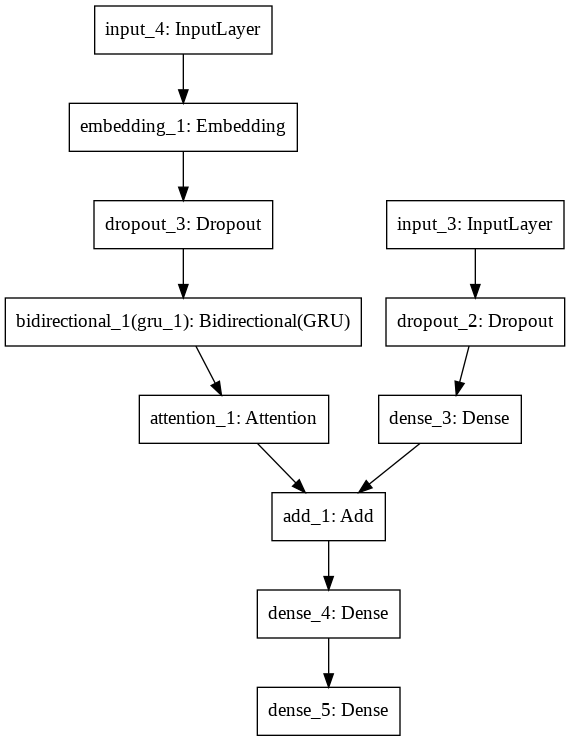

In [ ]:
from keras.utils import plot_model
#plot_model(model4, to_file=main_dir+'model4.png', show_shapes=True)
plot_model(model2)

#### Defining the custom data generator

In [ ]:
def data_generator(descriptions, categories, photos, wordtoix, max_length, num_photos_per_batch):

	image_dir ='images_v4_full(2)/'
	#in_layer = Input(shape=(224, 224, 3))
	#model = ResNet50V2(include_top=False, input_tensor=in_layer)

	X1, X2, y1, y2 = list(), list(), list(), list()
	n=0
	# loop for ever over images
	while 1:
		for key, desc in descriptions.items():
			n+=1
			# retrieve the photo feature
			temp=main_dir
			try:
			#	image_name = image_dir+key+'.jpg'
			#	image=  load_img(image_name,target_size=(224, 224,3))
			#	image = img_to_array(image)
			#	image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

			#	image = preprocess_input(image)
			#	photo = model.predict(image, verbose=0)
				photo = photos[key]
			
				for abc in range(1):
						# encode the sequence
				
					seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
						
					# split one sequence into multiple X, y pairs
					for i in range(1, len(seq)):
						# split into input and output pair
						in_seq, out_seq = seq[:i], seq[i]
						# pad input sequence
						in_seq = pad_sequences([in_seq], maxlen=max_length, dtype='float64')[0]
						# encode output sequence
						out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
						# store
					
						X1.append(photo)
						X2.append(in_seq)
						y1.append(out_seq)
						y2.append(categories[key])
			except KeyError:
				continue

			# yield the batch data
			if n==num_photos_per_batch:
				yield ([np.array(X1, dtype='float64'),
							np.array(X2, dtype='float64')], {'decoder_output':np.array(y1, dtype='float64'),
															'classifier_output':np.array(y2, dtype='float64')})
				
				X1, X2, y1, y2 = list(), list(), list(), list()
				n=0
			

#### Training the model

In [ ]:
epochs = 50
number_pics_per_batch = 128
steps = len(train_captions)//number_pics_per_batch
temp = main_dir

In [ ]:
generator = data_generator(train_captions,  train_categories, train_features, word_to_index, max_length_caption, number_pics_per_batch)
val_generator = data_generator(val_captions, val_categories, val_features, word_to_index,max_length_caption, number_pics_per_batch)
output_dir = main_dir + 'model4/'

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=1,min_lr=1e-7, factor = 0.5)

if os.path.exists(output_dir) == False:
  os.mkdir(output_dir)
  
history = model4.fit_generator(generator, validation_data = val_generator, 
                                    validation_steps = len(val_captions)//number_pics_per_batch
                                    ,epochs=epochs,
                                    #,epochs=1,
                                steps_per_epoch=steps,
                                verbose=1, 
                               callbacks=[reduce_lr], shuffle=True)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
274/274 [==============================] - 733s 3s/step - loss: 11.2560 - decoder_output_loss: 6.2064 - classifier_output_loss: 3.8927 - val_loss: 10.0930 - val_decoder_output_loss: 4.8874 - val_classifier_output_loss: 5.5239
Epoch 2/50
274/274 [==============================] - 344s 1s/step - loss: 8.2348 - decoder_output_loss: 4.8437 - classifier_output_loss: 1.9385 - val_loss: 8.9551 - val_decoder_output_loss: 4.6300 - val_classifier_output_loss: 4.0201
Epoch 3/50
274/274 [==============================] - 225s 820ms/step - loss: 7.6306 - decoder_output_loss: 4.5603 - classifier_output_loss: 1.5802 - val_loss: 8.2672 - val_decoder_output_loss: 4.3242 - val_classifier_output_loss: 3.5617
Epoch 4/50
274/274 [==============================] - 216s 789ms/step - loss: 7.1022 - decoder_output_loss: 4.2923 - classifier_output_loss: 1.3275 - val_loss: 7.6881 - val_decoder_output_loss: 4.0759 - val_classif

#### Saving the model

In [ ]:
model4.save(output_dir+'model_ajio_v4_50(2)_withjson.h5')
#model4.save(output_dir+'temp_model.h5')

#### Plotting the loss curves

dict_keys(['loss', 'decoder_output_loss', 'classifier_output_loss', 'val_loss', 'val_decoder_output_loss', 'val_classifier_output_loss', 'lr'])
loss


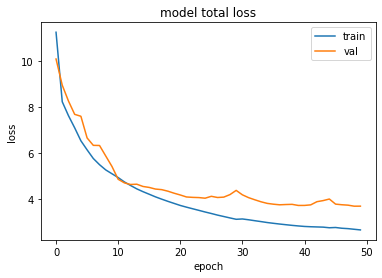

decoder_output_loss


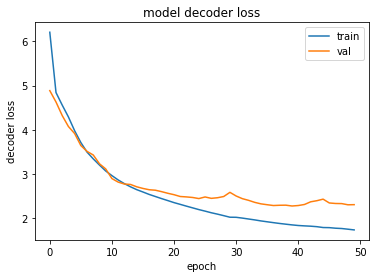

classifier_output_loss


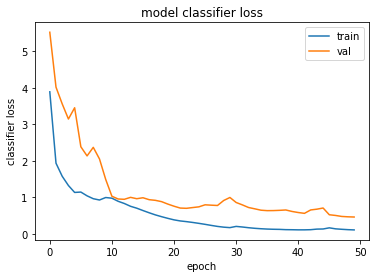

In [ ]:
import matplotlib.pyplot as plt
print(history.history.keys())
 
# summarize history for loss
print('loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model total loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('decoder_output_loss')
plt.plot(history.history['decoder_output_loss'])
plt.plot(history.history['val_decoder_output_loss'])
plt.title('model decoder loss')
plt.ylabel('decoder loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

print('classifier_output_loss')
plt.plot(history.history['classifier_output_loss'])
plt.plot(history.history['val_classifier_output_loss'])
plt.title('model classifier loss')
plt.ylabel('classifier loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()


#### Saving the corresponding data in a **JSON** file for using it while loading the mdoel later.

In [ ]:
import pandas as pd

encoded_data, mapping_index = pd.Series(list(unq_categories)).factorize()
print(mapping_index)

Categories_mapping = list(mapping_index)
print(Categories_mapping)

f= open('mapping.json','w')
data = {'word_to_index':word_to_index,
        'index_to_word':index_to_word,
        'categories_mapping':Categories_mapping}
json.dump(data,f)
f.close()

Index(['Women's Jackets', 'Men's Jackets', 'Women's Sarees', 'Women's Kurtas',
       'Women's Jeans', 'Women's Tops', 'Women's T-Shirts', 'Men's Shirts',
       'Men's Shoes', 'Men's T-shirts', 'Men's Jeans', 'Women's Shoes',
       'Women's Jewellery'],
      dtype='object')
["Women's Jackets", "Men's Jackets", "Women's Sarees", "Women's Kurtas", "Women's Jeans", "Women's Tops", "Women's T-Shirts", "Men's Shirts", "Men's Shoes", "Men's T-shirts", "Men's Jeans", "Women's Shoes", "Women's Jewellery"]


#### Loading the saved model

In [ ]:
from tensorflow.keras.models import load_model
output_dir = main_dir + 'model4/'
#model4.load_weights(output_dir+'ajio_v4_50(2).h5',by_name=True)
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.initializers import glorot_uniform

with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
        loaded_model4 = load_model(output_dir+'model_ajio_v4_50(1).h5', custom_objects={'Attention':Attention})

In [ ]:
test_features, test_product_ids = load_img_features(test_product_ids)

#### Testing the model **without category prediction**

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def greedySearch(photo):
  in_text = 'startseq'
  for i in range(max_length_caption):
    sequence = [word_to_index[w] for w in in_text.split(' ') if w in word_to_index]
    sequence = pad_sequences([sequence], maxlen = max_length_caption)
    yhat = model3.predict([photo,sequence],verbose=1)
    yhat = np.argmax(yhat)
    word = index_to_word[yhat]
    in_text+=' '+word
    if word == 'endseq':
      break
  final = in_text.split()
  final = final[1:-1]
  final = ' '.join(final)
  return final

print(len(test_product_ids))
z=173
pic= test_product_ids[z]
print(pic)
image = test_features[pic].reshape(1,7,7,512)
cv2_imshow(cv2.imread('images_v4_full(2)/'+pic+'.jpg'))
"""
plt.figure(figsize=(10,10))
plt.imshow(cv2.imread('images_v4_full/'+pic+'.jpg'))
plt.show()
"""
result = greedySearch(image)

print("Actual output:",test_captions[pic])
print("Predicted output:",result)

#### Testing the model **with category prediction**.

Women's Shoes_ajio_460457417_pewter


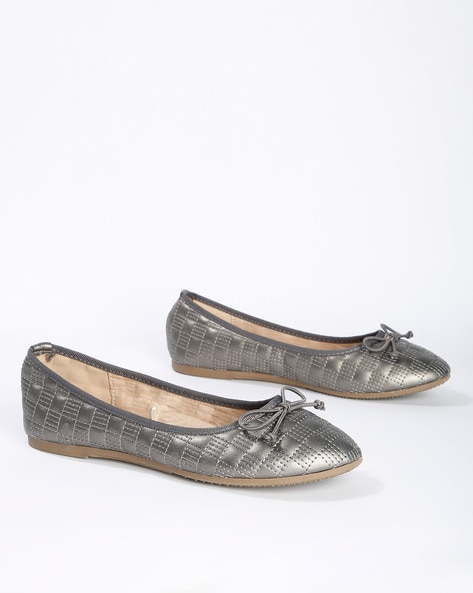

1/1 [==============================] - 0s 2ms/step
Women's Shoes
Actual output: startseq textured ballet flats with bow accent endseq
Predicted output: textured ballerinas with bow accent
Women's Shoes_ajio_460571880_white


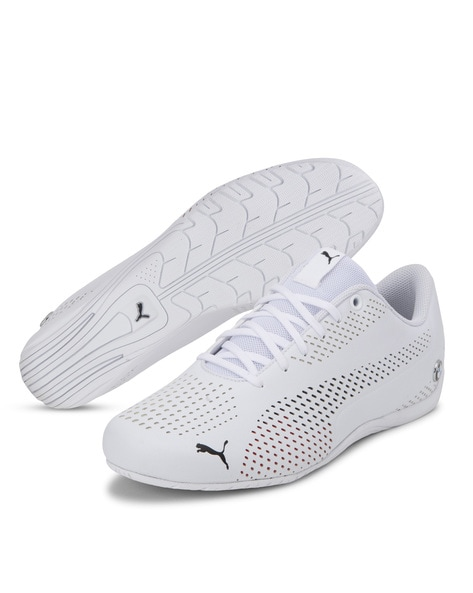

1/1 [==============================] - 0s 2ms/step
Women's Shoes
Actual output: startseq laceup casual shoes endseq
Predicted output: textured laceup casual shoes
Men's Jeans_ajio_460361992_blue


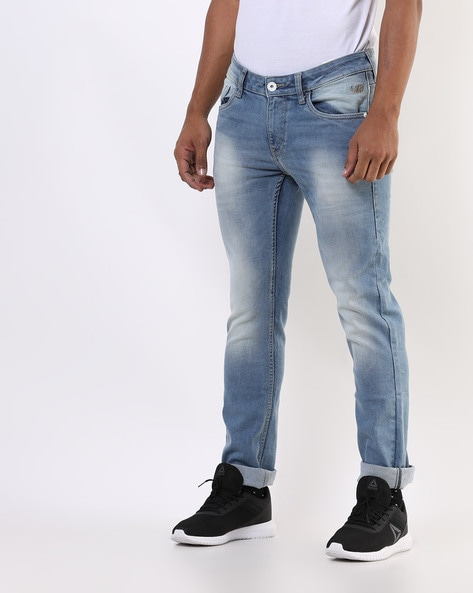

1/1 [==============================] - 0s 3ms/step
Men's Jeans
Actual output: startseq midwash lowrise skinny jeans endseq
Predicted output: lightly washed slim fit jeans
Men's T-shirts_ajio_440745963_navy


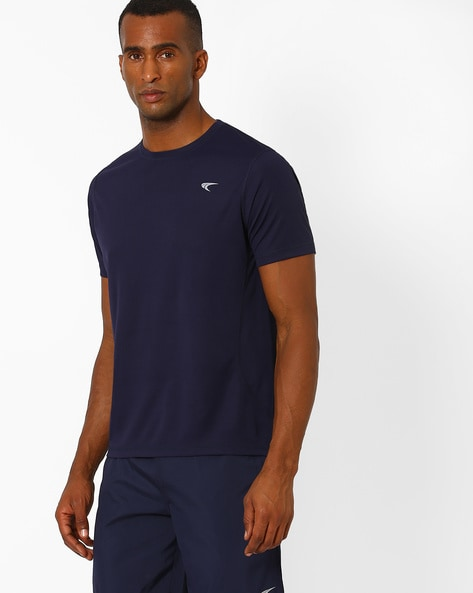

1/1 [==============================] - 0s 2ms/step
Men's T-shirts
Actual output: startseq panelled crewneck tshirt endseq
Predicted output: slim fit crewneck tshirt
Women's Jeans_ajio_460440624_indigo


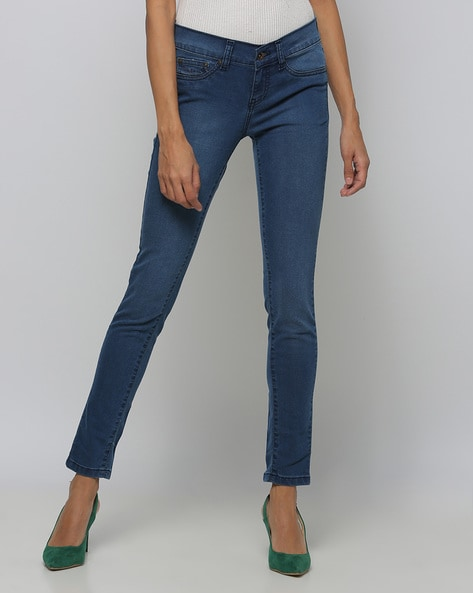

1/1 [==============================] - 0s 1ms/step
Women's Jeans
Actual output: startseq midwash skinny jeans endseq
Predicted output: lightly washed skinny jeans
Women's Jackets_ajio_460579256_blue


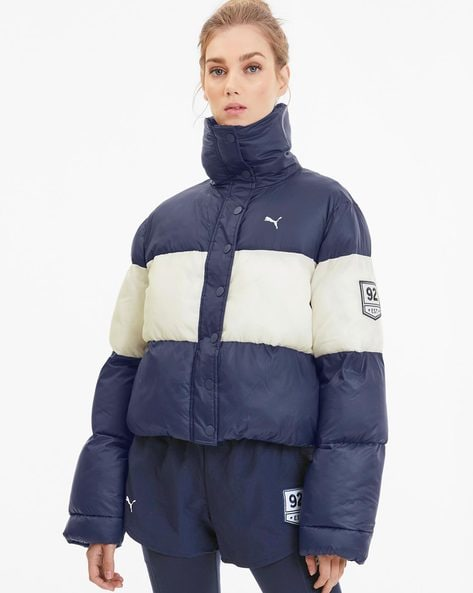

1/1 [==============================] - 0s 2ms/step
Men's Jackets
Actual output: startseq zipfront puffer jacket with high neck endseq
Predicted output: zipfront jacket with insert pockets
Men's T-shirts_ajio_441058239_black


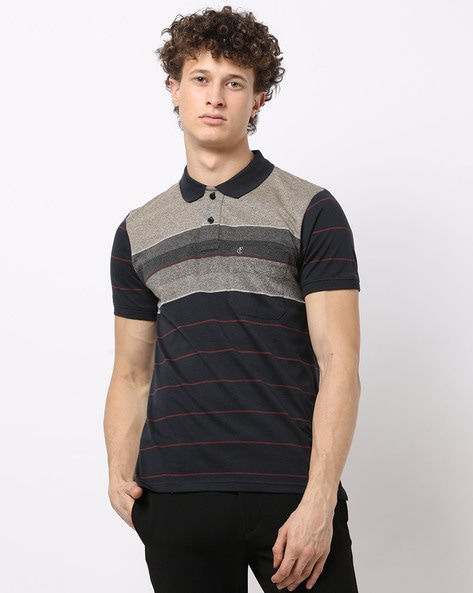

1/1 [==============================] - 0s 1ms/step
Men's T-shirts
Actual output: startseq striped pocket polo tshirt with contrast yoke endseq
Predicted output: graphic print slim fit tshirt
Women's Shoes_ajio_461152422_black


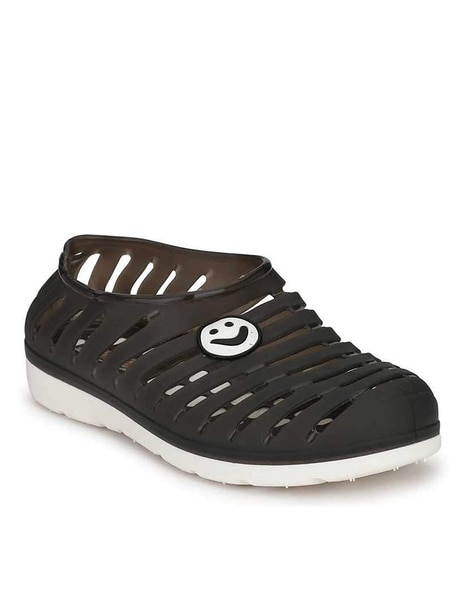

1/1 [==============================] - 0s 5ms/step
Women's Shoes
Actual output: startseq textured slipon shoes endseq
Predicted output: laceup casual shoes
Men's Shirts_ajio_440970298_orange


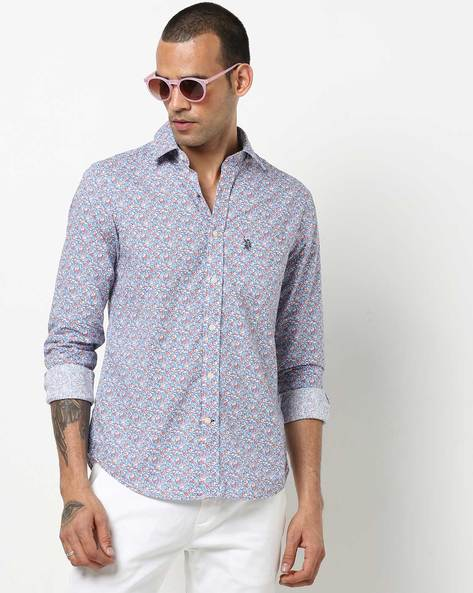

1/1 [==============================] - 0s 3ms/step
Men's Shirts
Actual output: startseq printed spreadcollar shirt with patch pocket endseq
Predicted output: checked slim fit shirt with patch pocket
Women's Kurtas_ajio_440994509_green


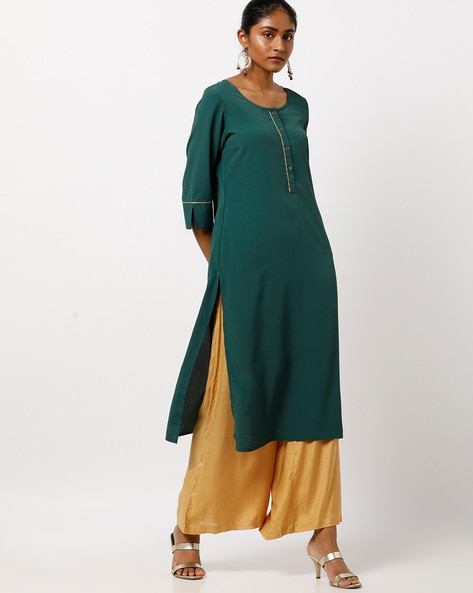

1/1 [==============================] - 0s 3ms/step
Women's Kurtas
Actual output: startseq straight kurta with insert pocket endseq
Predicted output: straight kurta with insert yoke


In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def greedySearch(photo):
	in_text = 'startseq'
	for i in range(max_length_caption):
		sequence = [word_to_index[w] for w in in_text.split(' ') if w in word_to_index]
		sequence = pad_sequences([sequence], maxlen = max_length_caption)
		yhat = loaded_model4.predict([photo,sequence],verbose=1)
		seq_yhat, cls_yhat = yhat
		seq_yhat = np.argmax(seq_yhat)
		cls_yhat+=cls_yhat
		
		word = index_to_word[seq_yhat]
		in_text+=' '+word
		if word == 'endseq':
			break
	cls_yhat = cls_yhat / (i+1)
	cls_yhat = np.argmax(cls_yhat)
	print(Categories_mapping[cls_yhat])
	final = in_text.split()
	final = final[1:-1]
	final = ' '.join(final)
	return final


for i in range(10):
		pic= test_product_ids[i]
		print(pic)
		image = test_features[pic].reshape(1,7,7,512)
		cv2_imshow(cv2.imread('images_v4_full(2)/'+pic+'.jpg'))

		result = greedySearch(image)

		print("Actual output:",test_captions[pic])
		print("Predicted output:",result)